### Funciones principales

In [7]:
%matplotlib inline
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
import os
import glob
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 7
rcParams["figure.subplot.hspace"] = (0.5)


def load_PEER_Data(filename):

    scalefactor = 1.0
    with open(filename,'r') as f:
        content = f.readlines()
    counter = 0
    desc, row4Val, acc_data = "","",[]
    for x in content:
        if counter == 1:
            desc = x
        elif counter == 3:
            row4Val = x
            if row4Val[0][0] == 'N':
                val = row4Val.split()
                npts = float(val[(val.index('NPTS='))+1].rstrip(','))
                dt = float(val[(val.index('DT='))+1])
            else:
                val = row4Val.split()
                npts = float(val[0])
                dt = float(val[1])
        elif counter > 3:
            data = str(x).split()
            for value in data:
                a = float(value) * scalefactor
                acc_data.append(a)
            inp_acc = np.asarray(acc_data)
            time = []
            for i in range (0,len(acc_data)):
                t = i * dt
                time.append(t)
        counter = counter + 1
        
    return (desc, npts, dt, time, inp_acc)



from scipy.fftpack import hilbert
from scipy.signal import  iirfilter
from scipy.signal import sosfilt
from scipy.signal import zpk2sos

def lowpass(data, freq, df, corners=4, zerophase=False):
    """
    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freq: Filter corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the number of corners but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    f = freq / fe
    z, p, k = iirfilter(corners, f, btype='lowpass', ftype='butter',
                        output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)
    
def highpass(data, freq, df, corners=4, zerophase=False):
    """
    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freq: Filter corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the number of corners but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    f = freq / fe
    
    z, p, k = iirfilter(corners, f, btype='highpass', ftype='butter',
                        output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)
    
    
def bandpass(data, freqmin, freqmax, df, corners=4, zerophase=False):
    """
    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freqmin: Pass band low corner frequency.
    :param freqmax: Pass band high corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the filter order but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    low = freqmin / fe
    high = freqmax / fe
    z, p, k = iirfilter(corners, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)

  

### Ejemplo # 1

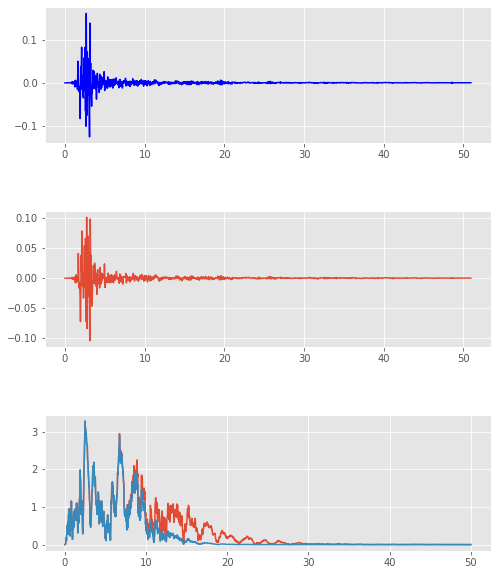

In [15]:
filename = 'C:\\Users\\obandohe\\Fundamentos\\REGISTROS\\RSN1_HELENA.A_A-HMC180.AT2' 
desc, npts, dt, time, acc = load_PEER_Data(filename)   
fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(8,10))
ax0.plot(time,inp_acc,color='blue')

# filtro paso bajo

fs = 1/dt

fc = 10
acc_filt = lowpass(acc, fc, fs, corners=4, zerophase=False)
ax1.plot(time,acc_filt)
#ax1.plot(time,y,color='blue')

# Calcular la tranformada rapida de Fourier --FFT

Y01 = np.fft.rfft(acc)              # FFT de senal original
Y02 = np.fft.rfft(acc_filt)         # FFT de senal filtrada
dt=1/fs
ny = 1/(2.*dt)
f = np.linspace(0, ny, len(Y01))    # vector de frecuencias

ax2.plot(f,abs(Y01))
ax2.plot(f,abs(Y02))
